In [1]:
import os
import math


import IPython
from functools import lru_cache
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
import plot_styling

from pypeg2 import *

import beoid.filename_parser
from beoid.gaze import *

import matplotlib
matplotlib.rcParams['figure.figsize'] = 5, 10
plot_styling.setup('paper')

def display_full(x):
    pd.set_option('display.max_rows', len(x))
    IPython.display.display(x)
    pd.reset_option('display.max_rows')
    

# C1_dark, C1_light, C2_dark, C2_light
palette = sns.color_palette(["#4B1CCC", "#3C70FF", "#CC771C", "#FFB641"])
sns.palplot(palette)
#sns.set_palette(palette)

In [2]:
attention_maps = pd.read_pickle('../attention-maps-beoid-with-metadata.pickle')
shifted_valid_gaze = pd.read_pickle('../beoid-gaze-valid-shifted.pickle')

In [3]:
shifted_valid_gaze.describe()

,frame,gaze_2d_x,gaze_2d_y,camera_3d_x,camera_3d_y,camera_3d_z,gaze_3d_x,gaze_3d_y,gaze_3d_z,fixation_3,fixation_5,fixation_9
count,58977.000000,58977.000000,58977.000000,58977.000000,58977.000000,58977.000000,58977.000000,58977.000000,58977.000000,54983.0,55267.0,58977.0
mean,1848.263255,244.051858,217.014310,304.928659,304.373219,305.567448,304.989290,304.422270,305.147618,1.0,1.0,1.0
std,1611.253810,54.682298,97.370581,151.608472,151.661389,151.808139,151.616307,151.658657,151.941223,0.0,0.0,0.0
min,5.000000,2.790000,-0.980000,-0.242086,-1.152930,0.288874,-0.448802,-0.533981,-0.698502,1.0,1.0,1.0
25%,489.000000,212.680000,142.010000,298.978000,300.038000,300.273000,298.979000,299.865000,299.984000,1.0,1.0,1.0
50%,1214.000000,241.520000,205.540000,399.458000,399.090000,400.795000,399.531000,399.297000,400.502000,1.0,1.0,1.0
75%,3175.000000,274.030000,289.450000,400.633000,399.469000,401.018000,400.705000,399.546000,400.697000,1.0,1.0,1.0
max,6203.000000,605.790000,479.740000,500.472000,500.829000,500.620000,500.349000,500.267000,500.512000,1.0,1.0,1.0


In [4]:
def scale_locations(src_shape, dest_shape, locations):
    assert(len(src_shape) == 2)
    assert(len(dest_shape) == 2)
    f1 = lambda x: int(x * dest_shape[0] / src_shape[0])
    f2 = lambda x: int(x * dest_shape[1] / src_shape[1])
    return (list(map(f1, locations[0])), list(map(f2, locations[1])))
print(scale_locations((10, 10), (20, 20), ([0, 5, 10], [0, 5, 10])))
print(scale_locations((10, 20), (20, 40), ([0, 5, 10], [0, 10, 20])))

([0, 10, 20], [0, 10, 20])
([0, 10, 20], [0, 20, 40])


<IPython.core.display.Javascript object>


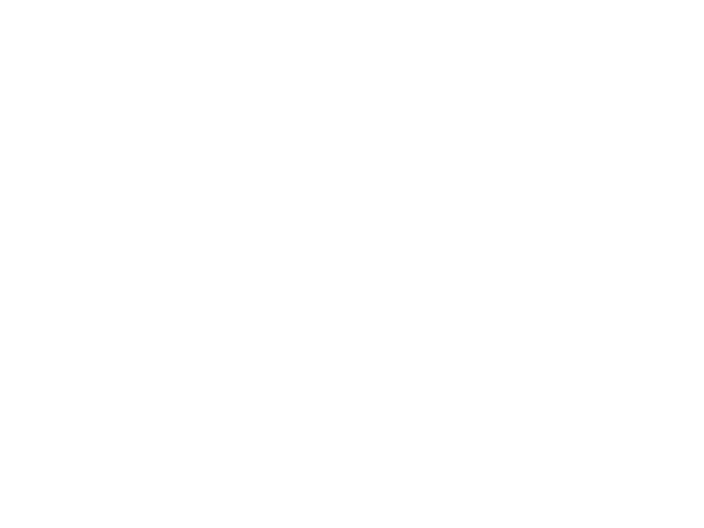

In [5]:
from scipy.signal import argrelmax

#TODO: Currently in the processof figuring out how to take the extrema values,
# order them by decreasing value, then take the top n
def peak_locations(attention_map, top_n=5):
    shape = attention_map.shape
    order = 1
    # argrelmax only looks for maxima across a single axis/dimension
    # so we have to look in both the X and Y directions for maxima,
    # then find where they both peak
    maxima_x_idx = argrelmax(attention_map, axis=0, order=order, mode='wrap')
    maxima_y_idx = argrelmax(attention_map, axis=1, order=order, mode='wrap')
    maxima_idx_pairs = set(zip(maxima_x_idx[0], maxima_x_idx[1])) & set(zip(maxima_y_idx[0], maxima_y_idx[1]))
    maxima_idx = (np.array(list(map(lambda x: x[0], maxima_idx_pairs))), np.array(list(map(lambda x: x[1], maxima_idx_pairs))))
    maxima_values = attention_map[maxima_idx]
    top_n_maxima_idx = maxima_values.argsort()[::-1][:top_n]
    return (maxima_idx[0][top_n_maxima_idx], maxima_idx[1][top_n_maxima_idx])


attention_map = attention_maps['Attention Map'].iloc[0]
slice_max_idx = peak_locations(attention_map)

%matplotlib notebook
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x_bounds = range(0, 28)
y_bounds = x_bounds
ax.plot_wireframe(*np.meshgrid(x_bounds, y_bounds), attention_map, cmap='viridis', rstride=1, cstride=1)
ax.scatter(slice_max_idx[1], slice_max_idx[0], attention_map[slice_max_idx], c='yellow', depthshade=False, s=100)

In [6]:
%matplotlib inline

In [7]:
from IPython.display import display, HTML
attention_map_with_gaze = pd.merge(attention_maps, shifted_valid_gaze, 
                                   left_on=['Video frame', 'Video'], 
                                   right_on=['frame', 'Video'],
                                   how='inner')
attention_map_with_gaze.drop(['camera_3d_' + dim for dim in list('xyz')] + 
                             ['gaze_3d_' + dim for dim in list('xyz')] + 
                             ['fixation_' + str(period) for period in [3, 5, 9]] + 
                             ['time', 'frame'], axis=1, inplace=True)
attention_map_with_gaze.sort_values(['Network', 'EBP Type', 'Clip', 'Frame'], inplace=True)
attention_map_with_gaze.groupby(['Network', 'EBP Type', 'Clip']).count()

Attention Map  \
Network  EBP Type        Clip                                                      
Spatial  Contrastive     00_Desk2_pick-up_plug_334-366                        32   
                         00_Desk2_pick-up_tape_1070-1099                      25   
                         00_Printer1_pull_drawer_173-220                      47   
                         00_Sink1_open_jar_1890-1938                          30   
                         00_Sink1_take_cup_1151-1188                          14   
                         00_Sink1_turn_tap_694-717                            23   
                         00_Sink2_pick-up_jar_1443-1471                        3   
                         00_Sink2_put_jar_1620-1659                           35   
                         01_Desk2_pick-up_tape_957-998                        37   
                         01_Desk2_switch-on_socket_736-785                    40   
                         01_Door2_scan_card-reader_79-125                     30   
                         01_Sink1_put_cup_520-569                              6   
                         01_Sink1_put_cup_799-826                             26   
                         01_Sink1_turn_tap_406-441                            35   
                         01_Sink2_pick-up_cup_156-181                          2   
                         01_Sink2_press_button_527-561                        34   
                         01_Sink2_put_jar_924-952                             18   
                         02_Desk1_place_tape_1258-1303                        14   
                         02_Desk1_plug_plug_437-519                           75   
                         02_Desk2_switch-on_socket_625-676                    38   
                         02_Door2_open_door_181-224                           13   
                         02_Printer1_press_button_447-485                     38   
                         02_Sink1_press_button_524-552                        16   
                         02_Sink1_put_cup_472-524                             31   
                         02_Sink1_rinse_cup_232-308                           28   
                         02_Sink1_scoop_spoon_1294-1332                       25   
                         02_Sink2_open_jar_1226-1252                          25   
                         02_Sink2_pick-up_jar_1003-1027                        3   
                         02_Sink2_pour_spoon_1319-1333                        14   
                         03_Desk1_insert_wire_429-509                         80   
...                                                                          ...   
Temporal Non-Contrastive 05_Treadmill1_press_button_4851-4867                  7   
                         05_Treadmill1_press_button_4879-4892                  4   
                         05_Treadmill2_press_button_2501-2518                  8   
                         05_Treadmill2_press_button_2966-2985                  8   
                         05_Treadmill2_press_button_4027-4056                 20   
                         05_Treadmill2_press_button_5008-5036                 19   
                         05_Treadmill3_press_button_203-221                    9   
                         05_Treadmill3_press_button_2298-2308                  1   
                         05_Treadmill3_press_button_2354-2370                  7   
                         05_Treadmill3_press_button_2370-2385                  6   
                         05_Treadmill3_press_button_2650-2667                  8   
                         05_Treadmill3_press_button_3775-3786                  2   
                         06_Row3_insert_weight-pin_407-450                    15   
                         06_Treadmill1_hold-down_button_331-528              155   
                         06_Treadmill1_press_button_1822-1835                  4   
                         06_Treadmi

In [8]:
frame_size = (640, 480)
frame_centre = (frame_size[0]/2, frame_size[1]/2)

def pair_euclidean_distance(p1, p2):
    return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2)

def distance_from_frame_center(row):
    gaze_2d_x = row['gaze_2d_x']
    gaze_2d_y = row['gaze_2d_y']
    return pair_euclidean_distance((gaze_2d_x, gaze_2d_y), frame_centre)
    
spatial_contrastive = attention_map_with_gaze[(attention_map_with_gaze['Network'] == 'Spatial') & \
                        (attention_map_with_gaze['EBP Type'] == 'Contrastive')]
clip_gaze = spatial_contrastive.drop(['Attention Map', 'Network', 'EBP Type', 'Window Size'], axis=1)
clip_gaze_from_frame_centre = clip_gaze.copy()
clip_gaze_from_frame_centre['Gaze Distance'] = clip_gaze.apply(distance_from_frame_center, axis=1)
clip_gaze_from_frame_centre.describe()

,Frame,Video frame,Operator,gaze_2d_x,gaze_2d_y,Gaze Distance
count,3758.000000,3758.000000,3758.000000,3758.000000,3758.000000,3758.000000
mean,37.880788,1265.473656,3.973390,255.092491,274.441786,119.758780
std,33.045563,1311.150672,1.796052,61.529945,89.807762,53.907733
min,1.000000,80.000000,0.000000,41.120000,4.320000,6.400195
25%,12.000000,394.250000,3.000000,221.132500,201.995000,77.441231
50%,28.000000,676.500000,4.000000,257.630000,263.525000,118.083258
75%,55.000000,1794.000000,5.000000,292.510000,350.865000,158.297622
max,164.000000,5036.000000,7.000000,475.660000,461.870000,303.748391


# Compare the operators' gaze  to the attention map's peak

Now we have the attention maps peaks and operator's gaze combined its time to compare them

In [9]:
video_shape = (640, 480)

def first(pair):
    return pair[0]

def second(pair):
    return pair[1]

def np_to_pairs(xs, ys):
    """
    >>> np_to_pairs(np.array([1, 3]), np.array([2, 4]))
    [(1, 2), (3, 4)]
    """
    return list(zip(xs, ys))


def pairs_to_np(pairs):
    """
    >>> pairs_to_np([(1, 2), (3, 4)])
    (array([1, 3]), array([2, 4]))
    """
    xs = np.array([first(pair) for pair in pairs])
    ys = np.array([second(pair) for pair in pairs])
    return (xs, ys)

max_dist = math.sqrt(first(video_shape)**2 + second(video_shape)**2)

def peak(row):
    attention_map = row['Attention Map']
    peak_idx = peak_locations(attention_map, top_n=1)
    scaled_peak_idx = scale_locations(attention_map.shape,
                                      (video_shape[1], video_shape[0]), peak_idx)
    return (scaled_peak_idx[1], scaled_peak_idx[0])

attention_map_with_gaze['Attention map peak'] = attention_map_with_gaze.apply(peak, axis=1)
    
def compare_gaze(row):
    scaled_peak_idx = row['Attention map peak']
    gaze_2d_x = row['gaze_2d_x']
    gaze_2d_y = row['gaze_2d_y']
    def distance_to_gaze(peak):
        return math.sqrt((gaze_2d_x - first(peak))**2 + (gaze_2d_y - second(peak))**2)
    return list(map(distance_to_gaze, np_to_pairs(*scaled_peak_idx)))

distances = attention_map_with_gaze.apply(compare_gaze, axis=1)
min_distances = distances.apply(min)
attention_map_with_gaze['Gaze Distance'] = min_distances

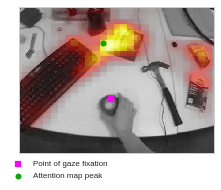

In [15]:
import dataset
from scipy.misc import imread, toimage
import visualisation
import caffe
from skimage.color import rgb2gray

beoid_dataset = dataset.ActionRecognitionDataSet('/home/will/thesis/generated/beoid/test-1')

attention_maps = attention_map_with_gaze.iloc[:10]
def read_frame(row):
    return rgb2gray(caffe.io.load_image(beoid_dataset.get_frame(row.Clip, row.Frame)))


def debug_peaks(row, ax, plot_gaze=True, plot_attention_map=True):
    frame = read_frame(row)
    
    frame = visualisation.overlay_attention_map(frame, row['Attention Map'])
    attention_map_peaks = row['Attention map peak']
    gaze_x = row['gaze_2d_x']
    gaze_y = row['gaze_2d_y']
    
    ax.imshow(frame)
    if plot_gaze:
        ax.scatter(gaze_x, gaze_y, c='#ff00ff', marker='s', label='Point of gaze fixation ') 
    if plot_attention_map:
        for peak_x, peak_y in np_to_pairs(*attention_map_peaks):
            ax.scatter(peak_x, peak_y, c='#00aa00', label='Attention map peak')

fig = plt.figure(figsize=(3.5, 3))
ax = fig.add_subplot(111)
row = attention_map_with_gaze.iloc[50]
debug_peaks(row, ax)
plt.xticks([])
plt.yticks([])
plt.legend(bbox_to_anchor=(0.5, 0))
plt.savefig('attention-map-gaze-peak-distance.png')
plt.show()

In [13]:
attention_map_with_gaze.head()

,Attention Map,Frame,Network,Clip,EBP Type,Window Size,Video frame,Video,Operator,Location,Object,Action,Type,gaze_2d_x,gaze_2d_y,Attention map peak,Gaze Distance
9170,"[[1.14305e-06, 1.05897e-06, 7.83642e-07, 8.145...",1,Spatial,00_Desk2_pick-up_plug_334-366,Contrastive,1,335,00_Desk2,0,Desk,plug,pick-up,Spatial Contrastive,257.69,292.69,"([251], [291])",6.900159
9174,"[[1.72225e-06, 1.53773e-06, 1.17958e-06, 1.265...",2,Spatial,00_Desk2_pick-up_plug_334-366,Contrastive,1,336,00_Desk2,0,Desk,plug,pick-up,Spatial Contrastive,258.75,295.56,"([251], [291])",8.992002
9178,"[[1.98981e-06, 1.9566e-06, 1.33608e-06, 1.1886...",3,Spatial,00_Desk2_pick-up_plug_334-366,Contrastive,1,337,00_Desk2,0,Desk,plug,pick-up,Spatial Contrastive,258.62,296.56,"([228], [291])",31.120701
9182,"[[1.78053e-06, 1.55064e-06, 1.15412e-06, 1.288...",4,Spatial,00_Desk2_pick-up_plug_334-366,Contrastive,1,338,00_Desk2,0,Desk,plug,pick-up,Spatial Contrastive,258.23,299.11,"([205], [291])",53.844266
9186,"[[2.48191e-06, 2.21118e-06, 1.83627e-06, 2.400...",5,Spatial,00_Desk2_pick-up_plug_334-366,Contrastive,1,339,00_Desk2,0,Desk,plug,pick-up,Spatial Contrastive,255.24,299.36,"([365], [257])",117.650445


In [ ]:
plt.figure(figsize=(3.5, 3))
ax = sns.violinplot(x='Network', 
               y='Gaze Distance', 
               hue='EBP Type',  
               split=True, 
               cut=0,
               data=attention_map_with_gaze)
plot_styling.prepare_figure()
plt.title('Distribution of attention map peak - gaze distance')
plt.legend(bbox_to_anchor=(0.5, 1.04))
plt.ylim(0)
plt.savefig('gaze-attention-map-peak-distance-distribution-beoid.pdf')

In [ ]:
gaze_distances = attention_map_with_gaze['Gaze Distance']
upper_limits = np.arange(0, max_dist, 1)

spatial_contrastive_distances = attention_map_with_gaze[(attention_map_with_gaze['Network'] == 'Spatial') & \
                       (attention_map_with_gaze['EBP Type'] == 'Contrastive')]['Gaze Distance']
spatial_non_contrastive_distances = attention_map_with_gaze[(attention_map_with_gaze['Network'] == 'Spatial') & \
                                               (attention_map_with_gaze['EBP Type'] == 'Non-Contrastive')]['Gaze Distance']
temporal_contrastive_distances = attention_map_with_gaze[(attention_map_with_gaze['Network'] == 'Temporal') & \
                                               (attention_map_with_gaze['EBP Type'] == 'Contrastive')]['Gaze Distance']
temporal_non_contrastive_distances = attention_map_with_gaze[(attention_map_with_gaze['Network'] == 'Temporal') & \
                                               (attention_map_with_gaze['EBP Type'] == 'Non-Contrastive')]['Gaze Distance']


def count_distances_under_limit(distances, upper_limit):
    return np.sum(distances < upper_limit)

def cumfreq(distances, upper_limits):
    cumulative_frequencies = np.array(list(map(lambda upper_limit: count_distances_under_limit(distances, upper_limit),
                                             upper_limits)), dtype=np.float64)
    cumulative_frequencies /= cumulative_frequencies.max()
    return cumulative_frequencies
    
def plt_distance_cum(ax, distances, upper_limits, **kwargs):
    cumulative_frequencies = cumfreq(distances, upper_limits)
    ax.plot(upper_limits, cumulative_frequencies, **kwargs)
    ax.set_ylim(0, 101)

    
fig, ax = plt.subplots(figsize=(4, 3))

plt_distance_cum(ax, spatial_contrastive_distances, upper_limits, label='Spatial Contrastive')
plt_distance_cum(ax, spatial_non_contrastive_distances, upper_limits, label='Spatial Non-contrastive')
plt_distance_cum(ax, temporal_contrastive_distances, upper_limits, label='Temporal Constrative')
plt_distance_cum(ax, temporal_non_contrastive_distances, upper_limits, label='Temporal Non-contrastive')
legend = plt.legend(loc='lower right', frameon=True)
plt.title("Cumulative frequency of attention maps with\npeak-gaze distance under N px")
plt.ylabel("Cumulative frequency density")
plt.xlabel("Peak-gaze distance (px)")
plt.xlim(0, 600)
plt.ylim(0, 1)
sns.despine(left=True, right=True)

plt.savefig('gaze-attention-map-peak-distance-cumfreq-beoid.pdf')

In [ ]:
percentiles = [.1, .25, .5, .75, .9]
temporal_non_contrastive_distances.describe(percentiles)

In [ ]:
cp = attention_map_with_gaze.groupby(['Network', 'EBP Type', 'Clip']).median()['Gaze Distance']
fig, ax = plt.subplots(figsize=(7, 5))
plt_distance_cum(ax, cp.loc['Spatial']['Contrastive'], upper_limits, label='Spatial contrastive')
plt_distance_cum(ax, cp.loc['Spatial']['Non-Contrastive'], upper_limits, label='Spatial Non-contrastive')
plt_distance_cum(ax, cp.loc['Temporal']['Contrastive'], upper_limits, label='Temporal contrastive')
plt_distance_cum(ax, cp.loc['Temporal']['Non-Contrastive'], upper_limits, label='Temporal Non-contrastive')
plt.legend(loc='lower right')
plt.xlim(0, 600)

In [ ]:
upper_limits = np.arange(0, max_dist, 1)
def count_under(row):
    return pd.DataFrame({
        'Upper Limit': upper_limits,
        'Count': list(map(lambda limit: count_distances_under_limit(row['Gaze Distance'], limit), upper_limits)),
    })

gaze_distances_by_action = pd.DataFrame()
gaze_distances_by_action = attention_map_with_gaze.groupby(['Network', 'EBP Type', 'Action']).apply(count_under)
gaze_distances_by_action.reset_index(inplace=True)
gaze_distances_by_action.head()

In [ ]:
grid = sns.FacetGrid(attention_map_with_gaze,
                     col="Action", 
                     hue="Type",
                     sharey=False,
                     col_wrap=4)
grid.map(sns.distplot, "Gaze Distance", hist=False)
for ax in grid.axes:
    ax.yaxis.set_visible(False)
grid.add_legend()

In [ ]:
grid = sns.factorplot(x='Network',
               y='Gaze Distance', 
               col='Action',
               hue='EBP Type',
               inner='quartiles',
               linewidth=1,
               col_wrap=5,
               kind='violin',
               legend=True,
               data=attention_map_with_gaze
              )

* turn: all turn tap actions in kitchen, spatial contrastive seems to 
  recognise tiles, spatial non contrastive highlights kitchen, like fairy 
  liquid bottle logo, rim of mug
* take: sink1/sink2, spatial non-contrastive highlights coffee machine, 
  contrastive highlights toaster, highlighting of mug on draining board
* rotate: two videos, both very short, just noise
* pour: single video, too small sample size
* scoop: two videos, edge of microwave
* insert: 8 videos, non-contrastive EBP on temporal network seems to suffer 
  from less noise highlighting, localises insert action well for gym videos

In [ ]:
plt.figure(figsize=(6, 4))
sns.factorplot(y='Gaze Distance', 
               x="Network",
               col="Location",
               hue='EBP Type',
               col_wrap=3,
               kind='violin',
               size=2,
               aspect=1,
               data=attention_map_with_gaze,
               cut=0,
               sharex=False,
               linewidth=0.8,
              )
sns.despine()
plt.ylim(0)
plt.savefig('gaze-attention-map-peak-distance-distribution-beoid-by-location.pdf')

In [ ]:
attention_map_with_gaze.groupby(['Network', 'EBP Type', 'Location'])['Attention Map'].count()

In [ ]:
sns.factorplot(y='Gaze Distance', 
               x='Network',
               col="Object",
               col_wrap=5,
               hue='EBP Type',
               kind='violin',
               size=3,
               aspect=0.8,
               legend=True,
               legend_out=True,
               data=attention_map_with_gaze
              )

In [ ]:
display_full(attention_map_with_gaze.groupby(['Network', 'EBP Type', 'Action']).count())

In [16]:
gaze_distance_average_per_clip = attention_map_with_gaze.groupby(['Network', 'EBP Type', 'Clip']).mean().reset_index()
idx_min = gaze_distance_average_per_clip.groupby(['Network', 'EBP Type'])['Gaze Distance'].idxmin()
idx_max = gaze_distance_average_per_clip.groupby(['Network', 'EBP Type'])['Gaze Distance'].idxmax()

display("min")
display(gaze_distance_average_per_clip.iloc[idx_min])
display("max")
display(gaze_distance_average_per_clip.iloc[idx_max])

'min'

,Network,EBP Type,Clip,Frame,Window Size,Video frame,Operator,gaze_2d_x,gaze_2d_y,Gaze Distance
44,Spatial,Contrastive,04_Printer2_press_button_370-409,20.0,1.0,390.0,4.0,268.794103,324.445897,28.834002
108,Spatial,Non-Contrastive,01_Sink1_put_cup_799-826,13.5,1.0,812.5,1.0,221.741923,358.222692,24.841853
226,Temporal,Contrastive,03_Sink2_stir_spoon_1793-1887,43.0,10.0,1836.0,3.0,261.425529,320.429412,24.807083
313,Temporal,Non-Contrastive,02_Sink2_pour_spoon_1319-1333,3.0,10.0,1322.0,2.0,233.470000,430.054000,12.164890


'max'

,Network,EBP Type,Clip,Frame,Window Size,Video frame,Operator,gaze_2d_x,gaze_2d_y,Gaze Distance
20,Spatial,Contrastive,02_Door2_open_door_181-224,7.000000,1.0,188.000000,2.0,242.419231,405.642308,486.872204
116,Spatial,Non-Contrastive,02_Door2_open_door_181-224,7.000000,1.0,188.000000,2.0,242.419231,405.642308,423.114469
199,Temporal,Contrastive,01_Desk2_pick-up_tape_957-998,16.500000,10.0,973.500000,1.0,74.757813,304.517500,456.948746
312,Temporal,Non-Contrastive,02_Sink2_pick-up_jar_1003-1027,12.666667,10.0,1015.666667,2.0,175.643333,342.496667,457.917272


Checking the gaze location and the attention map peaks aren't insane

* For a given frame, overlay the attention map
* Find the peak of the attention map, plot this on the frame
* Plot the gaze location on the frame

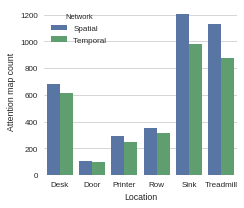

In [52]:
map_counts = attention_map_with_gaze[attention_map_with_gaze['EBP Type'] == 'Contrastive'].groupby(
    ['Network', 'EBP Type', 'Location']
).count().reset_index().drop('EBP Type', axis=1)
map_counts

#sns.barplot(map_counts, )
plt.figure(figsize=(3.5, 3))
sns.barplot(data=map_counts, x='Location', y='Attention Map', hue='Network')
plt.ylabel('Attention map count')
plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.savefig('beoid-gaze-attention-map-count.pdf')
plt.show()